### Ranking mutations by transmissibility

This assumes you've acquired GISAID data and run
```sh
make update               # ~30 minutes on CPU
python rank_mutations.py  # ~30 minutes on GPU
python rank_mutations --hessian --num-features=0  # ~1 minute on GPU
python rank_mutations --full --num-features=0  # ~5 minutes on GPU
```

In [1]:
import math
import pickle
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyrocov import pangolin

torch.set_default_dtype(torch.double)
matplotlib.rcParams['figure.dpi'] = 200

## Loading data

In [2]:
results = torch.load("results/rank_mutations.pt", map_location="cpu")
print(results.keys())
print("initial_ranks:", results['initial_ranks'].keys())
print("dropout keys:", list(results['dropouts'].keys())[:5], "...")
for fit in results['dropouts'].values(): 
    print("fit[0] keys:", fit.keys())
    print("loss_terms:")
    display(fit['loss_terms'])
    break

dict_keys(['args', 'mutations', 'initial_ranks', 'dropouts'])
initial_ranks: dict_keys(['losses', 'mean', 'std', 'median', 'args', 'ranks', 'cond_data'])
dropout keys: [None, 52, 1926, 183, 162] ...
fit[0] keys: dict_keys(['guide', 'mode', 'losses', 'loss_terms', 'args', 'mutation'])
loss_terms:


{'model': {'feature_scale': -0.7485630512237549,
  'rate_coef': -2658.71728515625,
  'rate': 0.0,
  'init': -902284.5,
  'concentration': -6.032129287719727,
  'obs': -187331.125},
 'guide': {'rate_coef': 0.0, 'init': 0.0}}

In [3]:
h = results["hessian"] = torch.load("results/rank_mutations.hessian.pt", map_location="cpu")
print(h.keys())
print(h["std"].min(), h["std"].mean(), h["std"].max())

dict_keys(['args', 'mutations', 'initial_ranks', 'mean', 'hessian', 'cov', 'var', 'std', 'ranks'])
tensor(0.1053) tensor(0.8084) tensor(5.7831)


In [4]:
full = torch.load("results/rank_mutations.rank_full_svi.pt", map_location="cpu")
print(full.keys())

dict_keys(['params', 'cond_data', 'losses', 'args', 'mean', 'cov', 'var', 'std', 'ranks'])


## Assessing model accuracy

The inference approach in `rank_mutations.py` is to:
1. Fit a mean-field variational model via stochastic variational inference (SVI).
2. Initially rank mutations by `|mean|/stddev` of their growth rate coefficietns `rate_coef`.
3. Fit MAP model parameters via (SVI).
4. For each of most postitive and most negative mutations, fit MAP model parameters with that feature removed.
5. Rank features by the change in loss for base-model versus model-with-feature-removed.

Let's examine the initial versus final ranking metric.

In [5]:
dropouts = results["dropouts"]
initial_ranks = results["initial_ranks"]
mode = dropouts[None]["mode"].detach()
feature_ids = torch.tensor(sorted([k for k in results["dropouts"] if k is not None]))
mode = mode[feature_ids]
mean = initial_ranks["mean"][feature_ids].detach()
sigma = mean / initial_ranks["std"][feature_ids].detach()
log_likelihood = torch.tensor([dropouts[i]["loss_terms"]["model"]["obs"]
                               for i in feature_ids.tolist()])
log_likelihood -= dropouts[None]["loss_terms"]["model"]["obs"]
elbo = -torch.tensor([dropouts[i]["losses"][-1] for i in feature_ids.tolist()])
elbo += dropouts[None]["losses"][-1]
mutations = [results["mutations"][i] for i in feature_ids.tolist()]

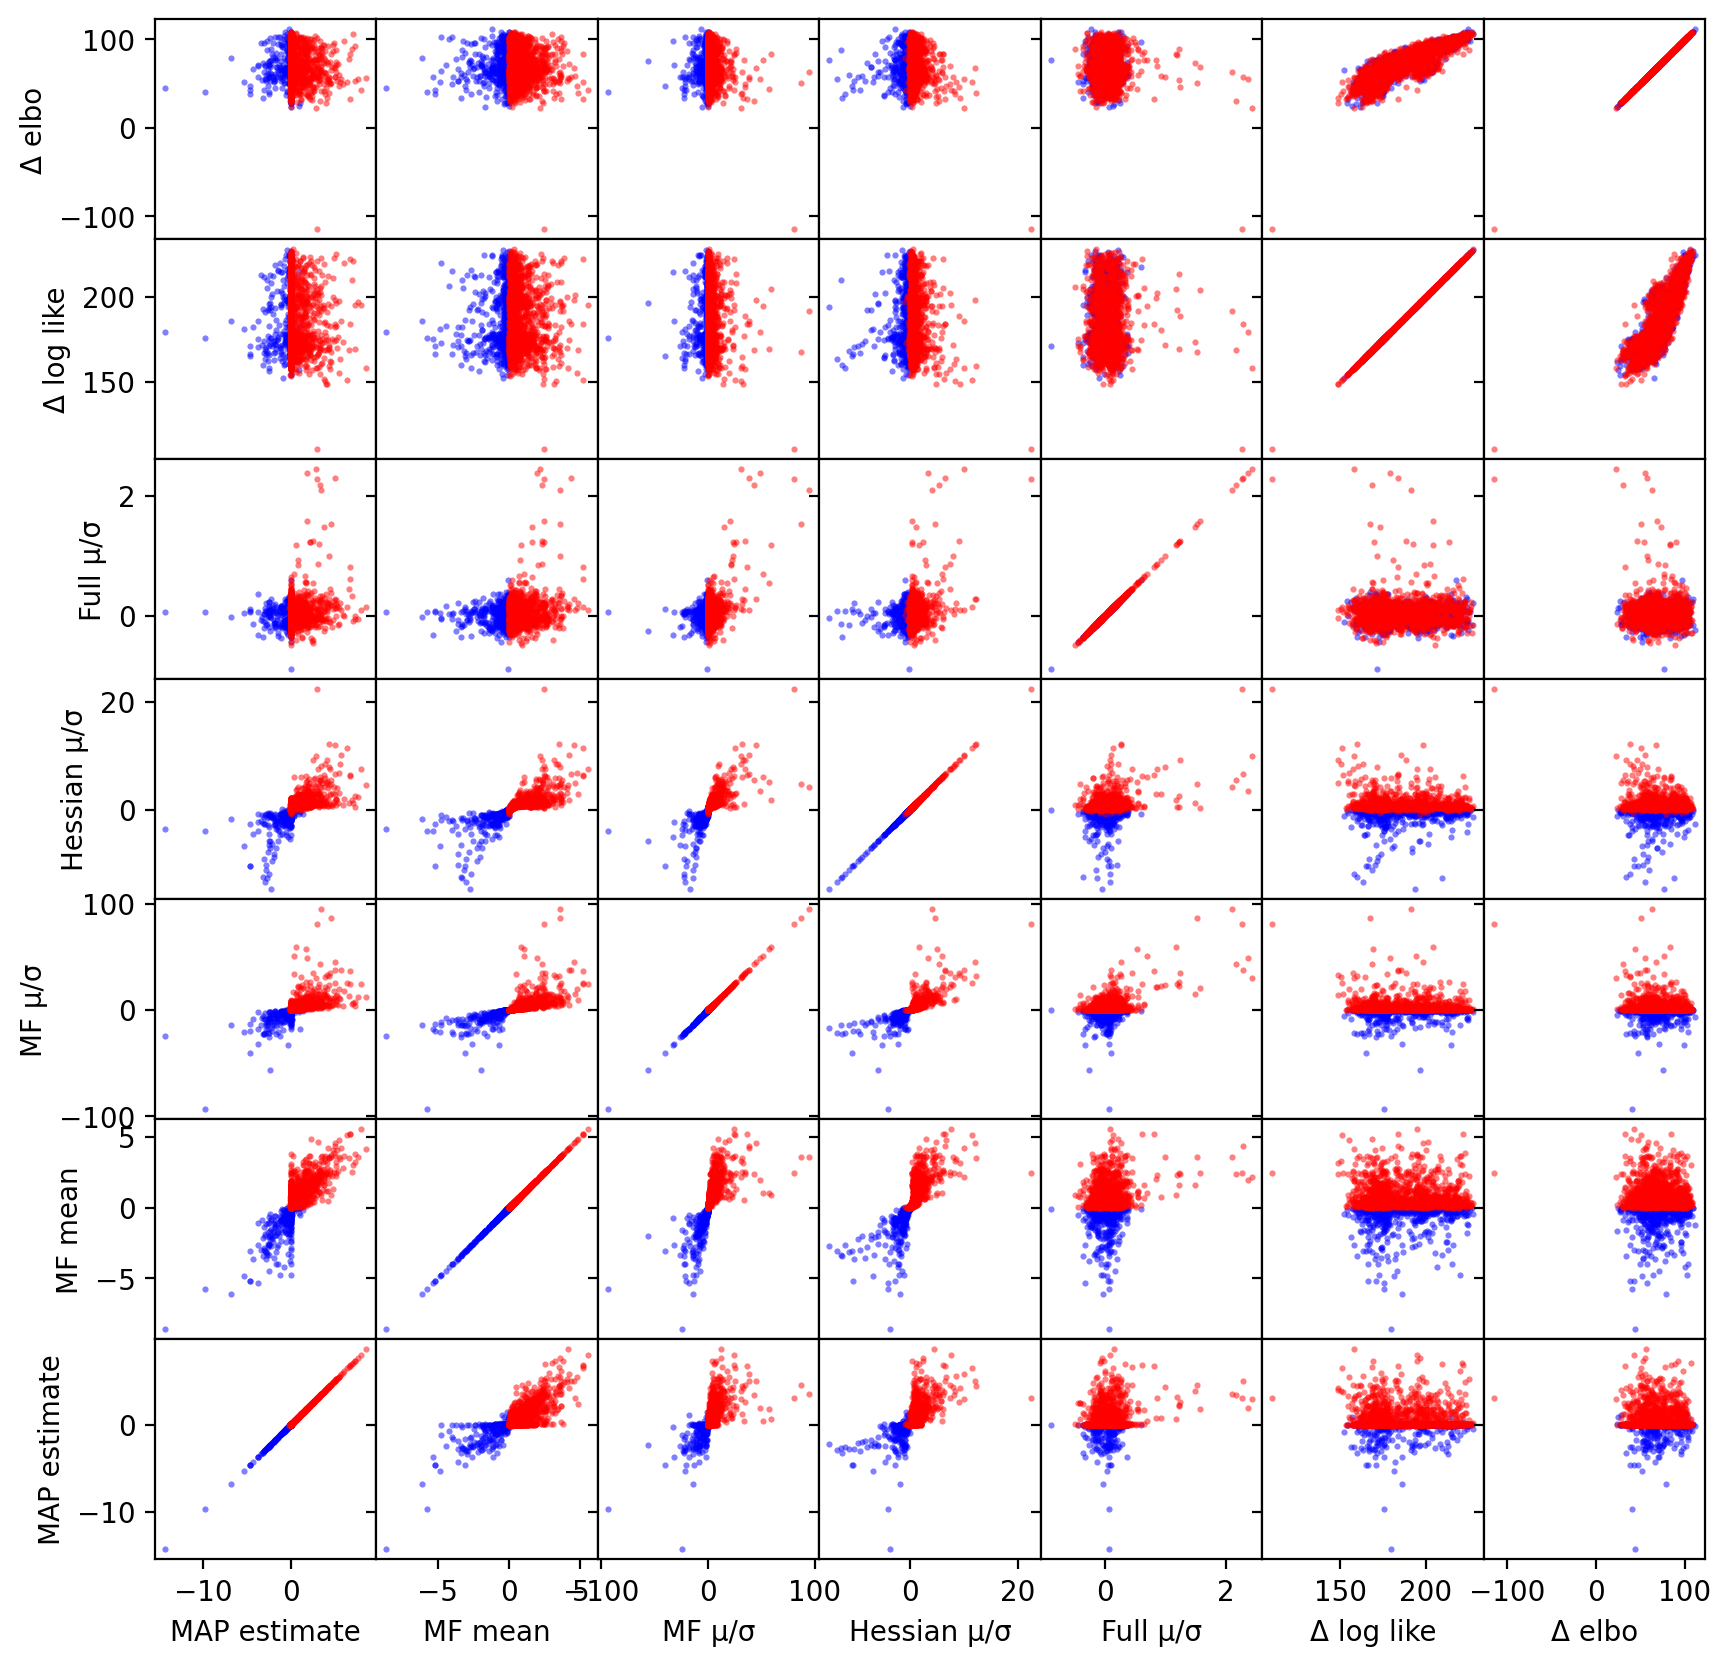

In [6]:
trends = {
    "MAP estimate": mode,
    "MF mean": mean,
    "MF μ/σ": sigma,
    "Hessian μ/σ": results["hessian"]["mean"] / results["hessian"]["std"],
    "Full μ/σ": full["mean"] / full["std"],
    "Δ log like": log_likelihood,
    "Δ elbo": elbo,
}
trends = list(trends.items())
pos = mean > 0
fig, axes = plt.subplots(len(trends), len(trends), figsize=(10, 10), sharex="col", sharey="row")
for i, (axes_i, (name_i, trend_i)) in enumerate(zip(axes, reversed(trends))):
    axes[i][0].set_ylabel(name_i)
    for j, (ax, (name_j, trend_j)) in enumerate(zip(axes_i, trends)):
        axes[-1][j].set_xlabel(name_j)
        ax.scatter(trend_j[~pos].numpy(), trend_i[~pos].numpy(),
                   5, color='blue', alpha=0.5, lw=0)
        ax.scatter(trend_j[pos].numpy(), trend_i[pos].numpy(),
                   5, color='red', alpha=0.5, lw=0)
plt.subplots_adjust(wspace=0, hspace=0)

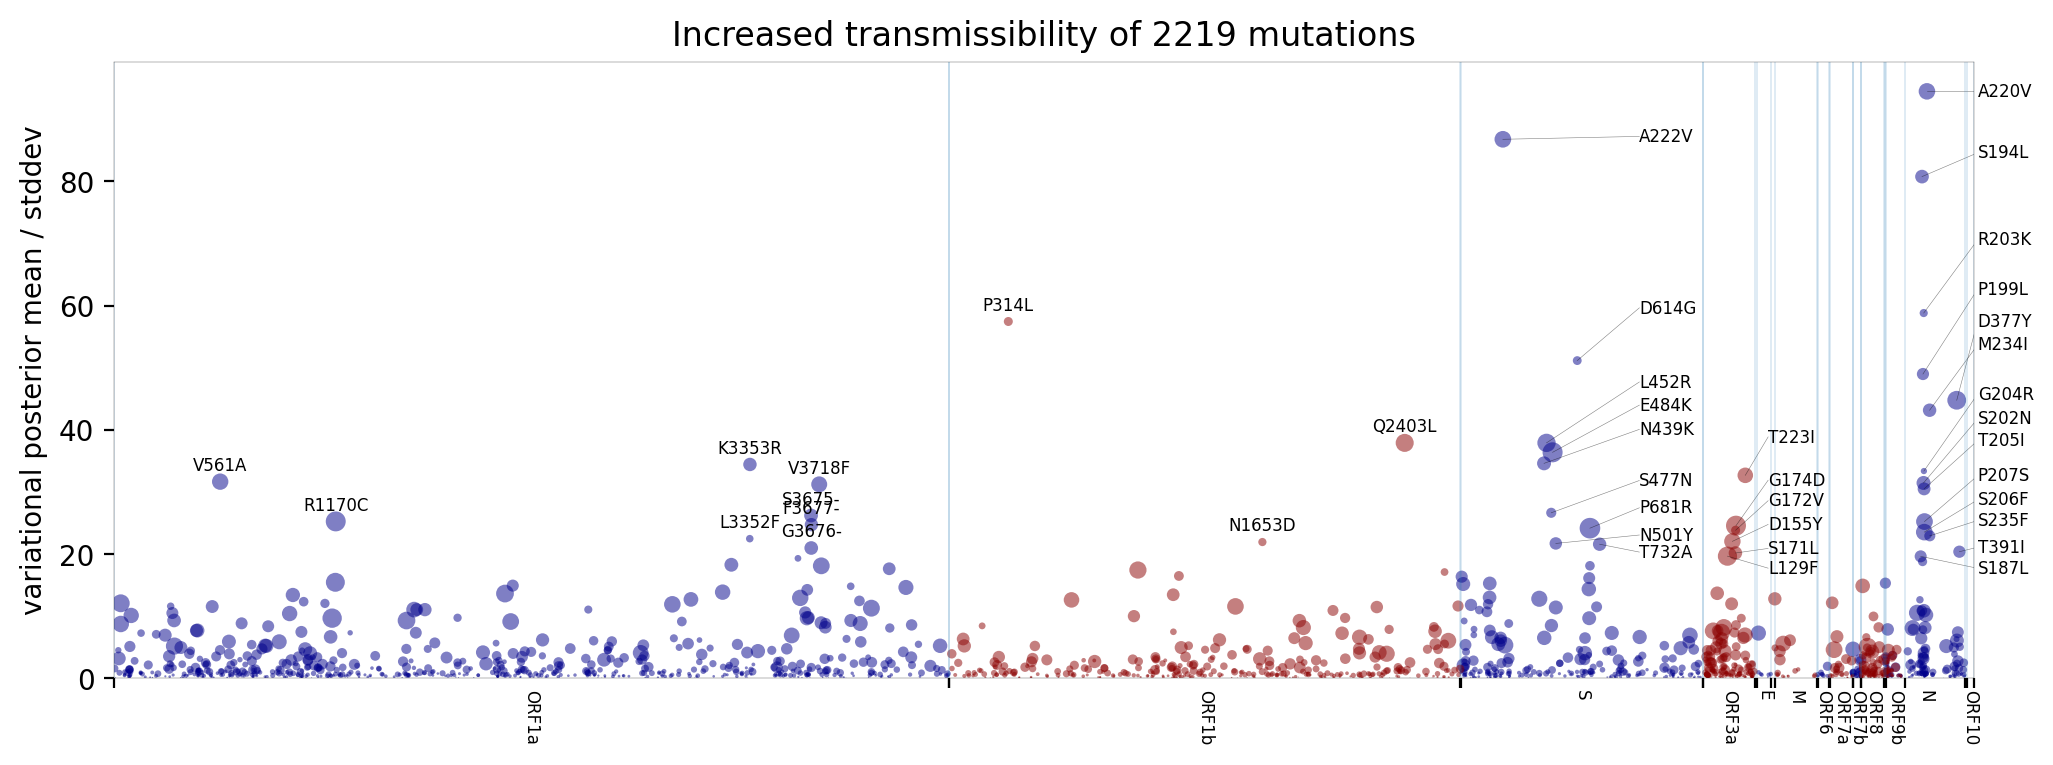

In [7]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(rankby, radius, top_k=40, in_gene=None):
    y1 = rankby.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(position) == len(radius)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (radius > 0)
    odd = (gene_ids % 2 == 1) & (radius > 0)

    plt.figure(figsize=(12, 4))
    if in_gene is None:
        plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    else:
        start, end = GENE_TO_POSITION[in_gene]
        num_mutations = sum(1 for p in position.tolist() if start <= p <= end)
        plt.title(f"Increased transmissibility of {num_mutations} mutations in {in_gene} gene")
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), rankby[mask].numpy(), 10 * radius[mask].numpy(),
                    color=color, alpha=0.5, lw=0)
    special = {} if in_gene else {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in rankby.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(rankby[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        if in_gene in (None, gene):
            plt.text(x, y + y1/80, name, fontsize=6,
                     verticalalignment="bottom", horizontalalignment="center")
    if special:
        for special_ in special.values():
            special_.sort(reverse=True)
        y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                    for k, v in special.items()}
        y_bounds = {k: (lb * 0.8, ub * 0.8 + y1 * 0.2) for k, (lb, ub) in y_bounds.items()}
        for i, (y, x, name) in enumerate(special["S"]):
            lb, ub = y_bounds["S"]
            y_label = 0.7 * y + 0.3 * (ub + (lb - ub) * (i / (len(special["S"]) - 0.99)))
            x_label = GENE_TO_POSITION["S"][1] - 1000
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        for gene in ["N", "ORF3a"]:
            for i, (y, x, name) in enumerate(special[gene]):
                lb, ub = y_bounds[gene]
                y_label = 0.5 * y + 0.5 * (ub + (lb - ub) * (i / (len(special[gene]) - 0.99)))
                x_label = GENE_TO_POSITION[gene][1] + 200
                plt.text(x_label, y_label, name, fontsize=6,
                         verticalalignment="center", horizontalalignment="left")
                plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    if in_gene is None:
        start_end = list(GENE_TO_POSITION.values())
        plt.xlim(start_end[0][0], start_end[-1][-1])
        xticks = []
        for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
            if gene == "ORF14":
                continue  # skip overlapping frame
            if in_gene not in (None, gene):
                continue
            plt.axvline(start, lw=0.1)
            plt.axvline(end, lw=0.1)
            xticks.extend([start, end])
            plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                     fontsize=6, verticalalignment="top", horizontalalignment="center")
        plt.xticks(xticks, labels=())
    else:
        start, end = GENE_TO_POSITION[in_gene]
        plt.xlim(start, end)
        xticks = [start]
        while xticks[-1] + 300 < end:
            xticks.append(xticks[-1] + 300)
        labels = [str((x - start) // 3) for x in xticks]
        plt.xticks(xticks, labels)
        plt.xlabel("amino acid position")
    plt.ylim(None if radius.ge(0).all() else 0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("variational posterior mean / stddev")

plot_manhattan(sigma, mean)

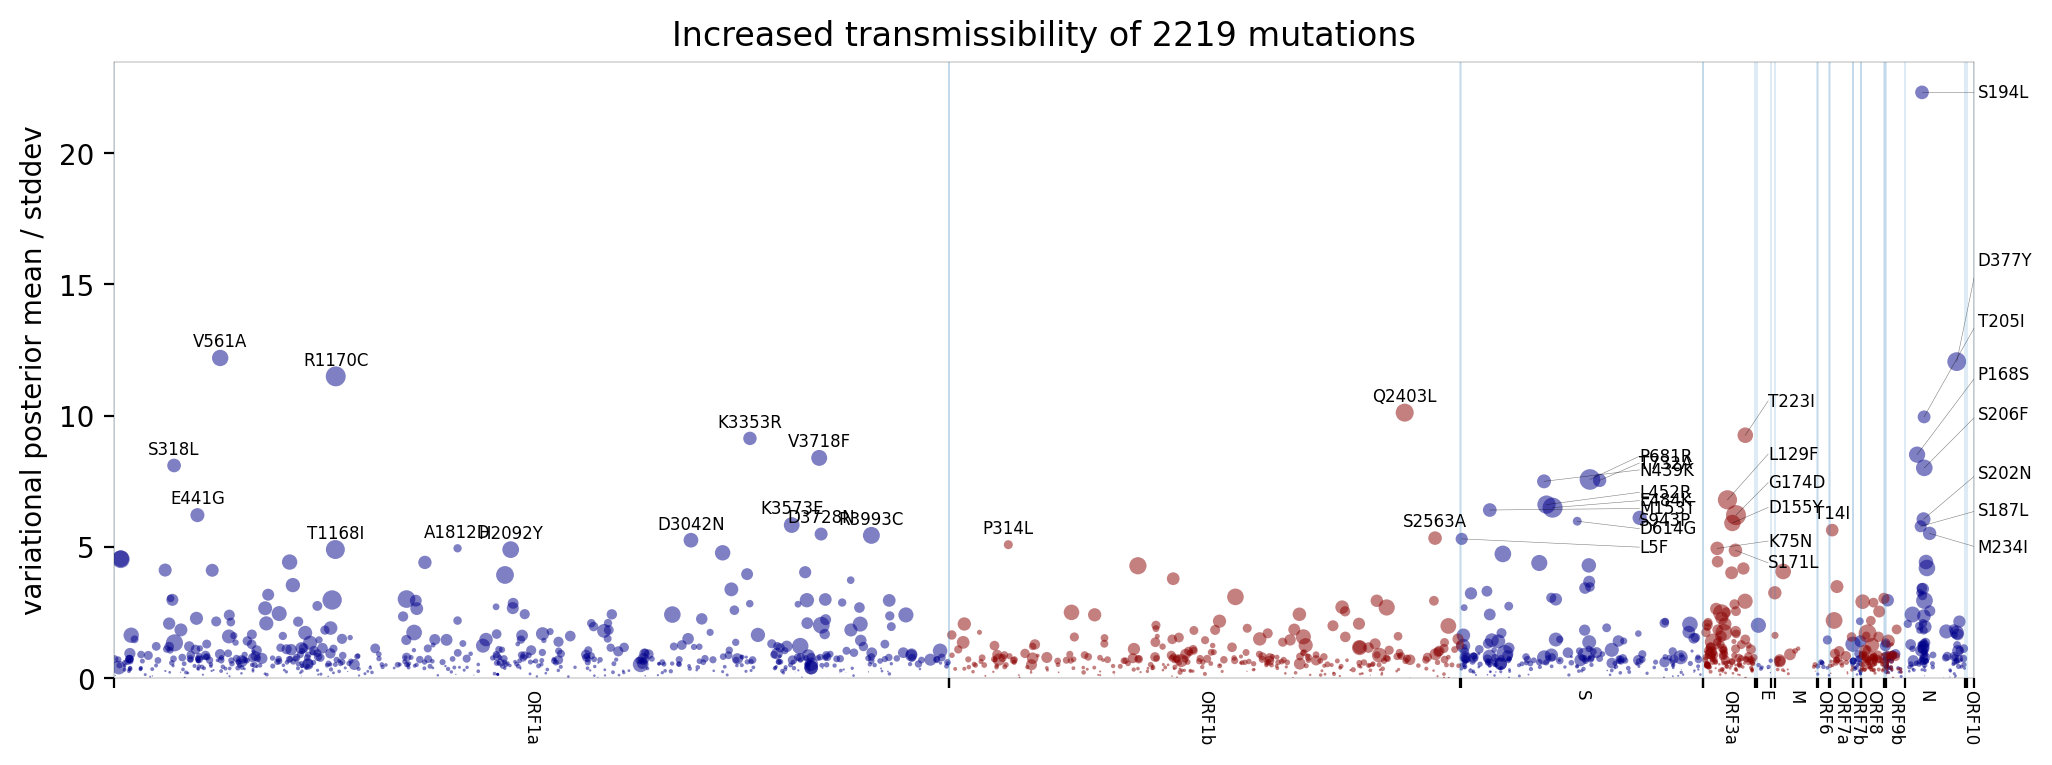

In [8]:
plot_manhattan(h["mean"] / h["std"], mean)
# plt.yscale("symlog", linthresh=20)

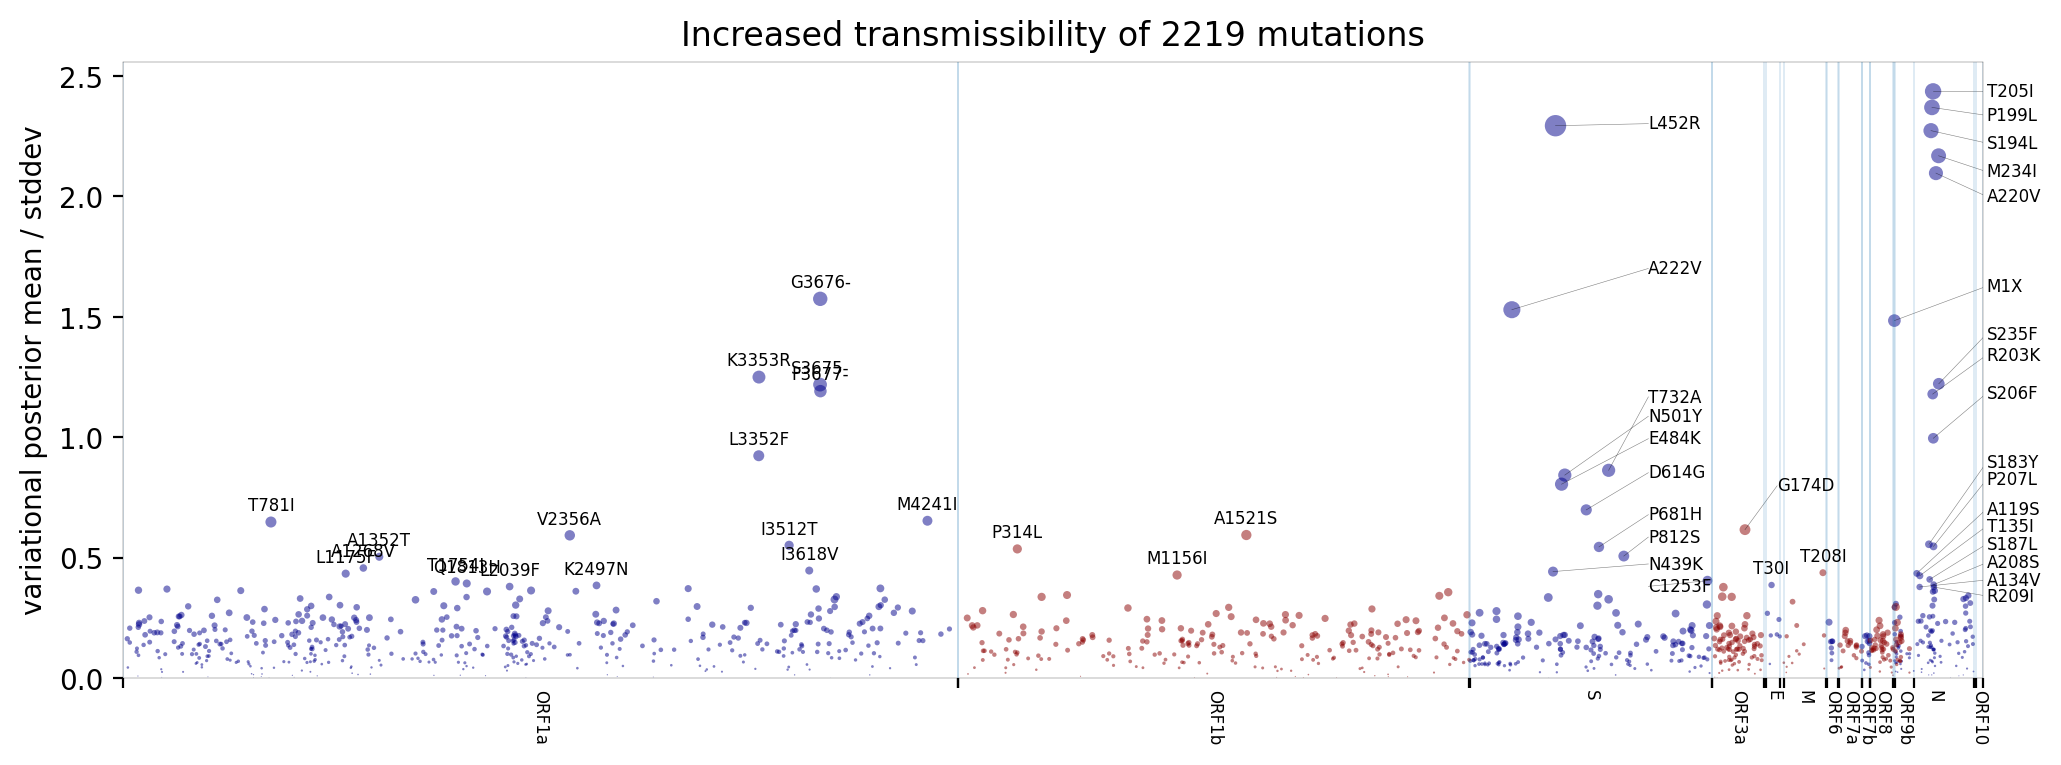

In [16]:
plot_manhattan(full["mean"] / full["std"], full["mean"], top_k=50)

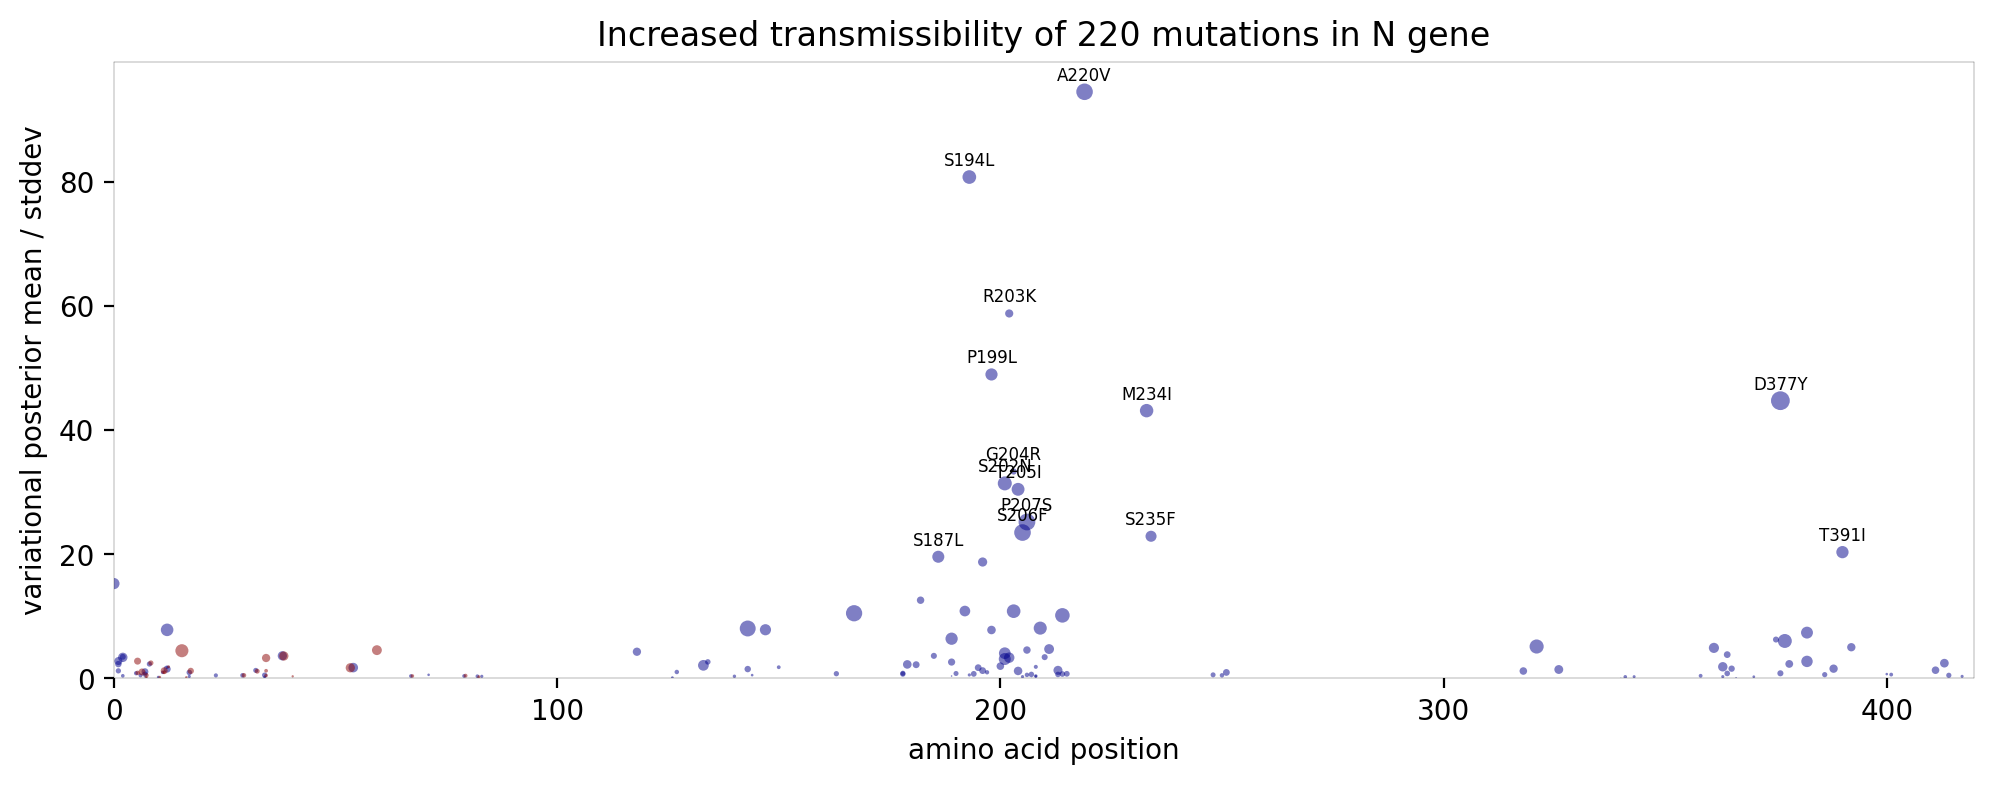

In [10]:
plot_manhattan(sigma, mean, in_gene="N")

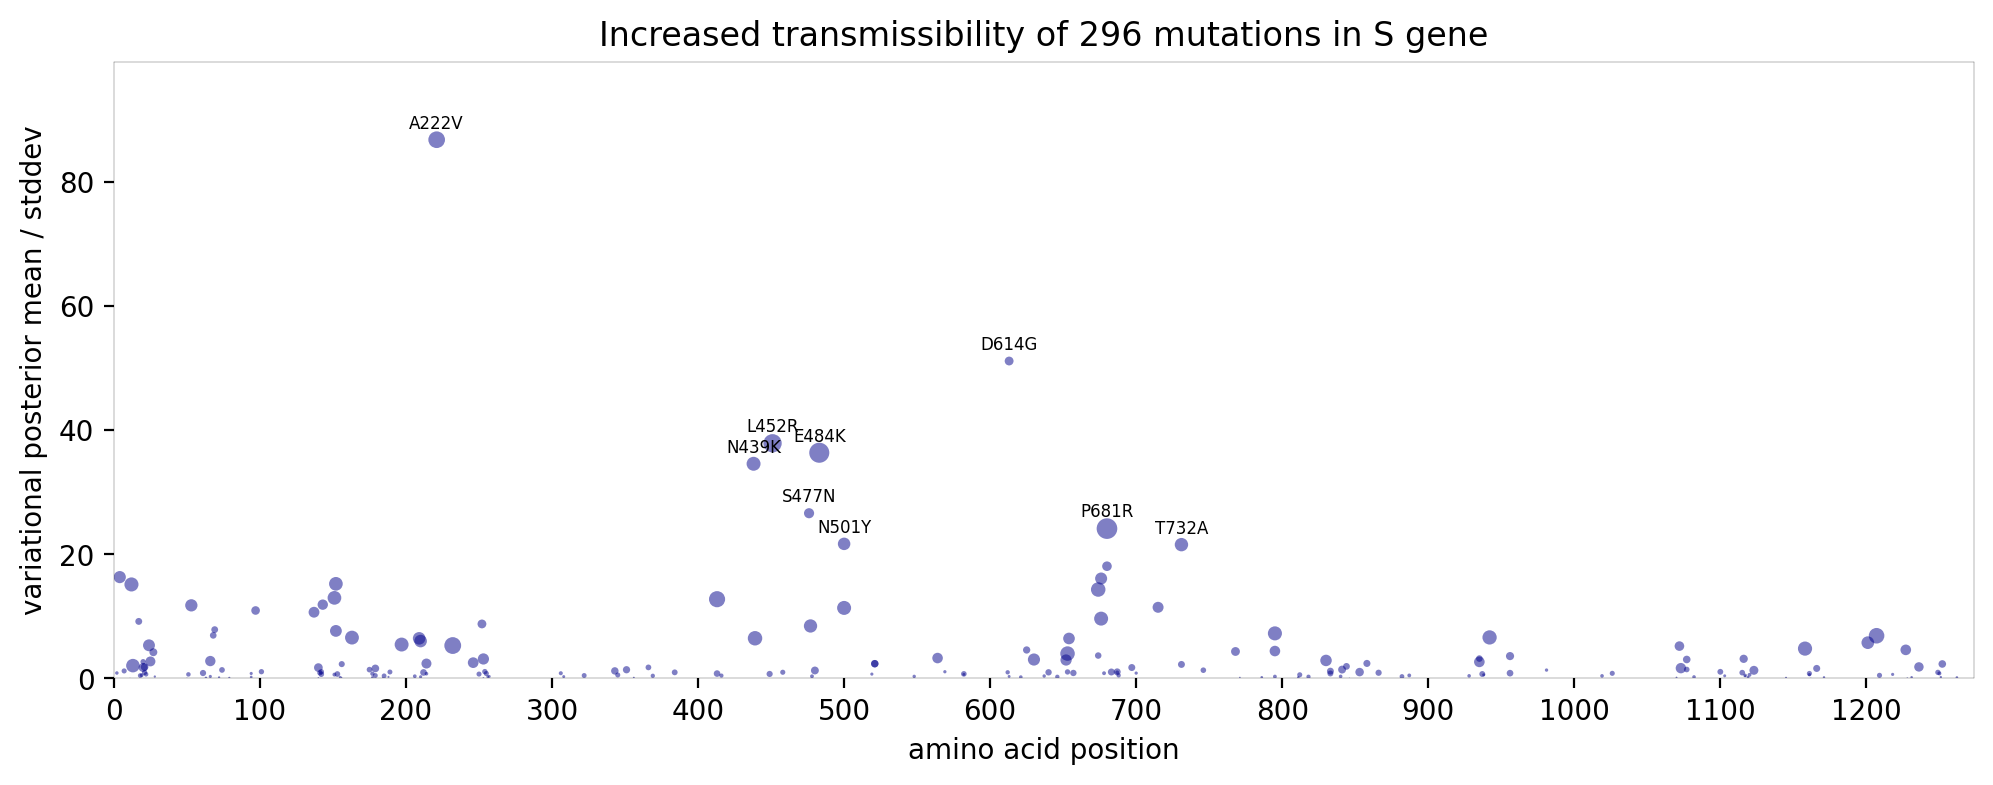

In [11]:
plot_manhattan(sigma, mean, in_gene="S")